# Predict Loan's Ever Delinquent Probability
#### Code updated on 12/19/17

In [1]:
get_ipython().magic(u'matplotlib inline')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats, integrate

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from IPython.core import display as ICD

In [3]:
def read_loan(path, filename):
    df = pd.read_csv(path + "\\" + filename, sep='\t', header=0)
    df.columns = col_names
    '''
    Args: 
        path: Location of the import file
        filename: Name of the import file
    Returns:
        df: Imported loan level details data frame
    '''
    return df

def agg_column(df, col_name):
    '''
    Args: 
        df: Data frame the aggregation calculation is based on 
        col_name: Name of aggregated column
    Returns:
        agg_series: The return is a data series. All calcuated values <=1
    '''
    agg_series = df.groupby(col_name).loan_id.nunique() / df.loan_id.nunique()
    return agg_series

def percent_format(float_series, rename_col_index):
    '''
    Args: 
        float_series: Data series with float value
        rename_col_index: The index of column which needs 
                          to be renamed for clarification
    Returns:
        percent_df: The return is a data frame with float formated as %
    '''
    percent = float_series.mul(100).round(1).astype(str) + '%'
    percent_df = pd.DataFrame(percent).reset_index()
    percent_df.rename(columns={percent_df.columns[rename_col_index]: "percent" }, inplace=True)
    #percent_df.rename(columns = {'loan_id':'percent'}, inplace=True)  # Alt: rename a column by name
    return percent_df

# Create histogram method
def histogram(df, title_name):
    '''
    Args: 
        df: Data frame or data series for plotting histogram on feature value distribution 
        title_name: Name of histogram
    Returns:
        Histogram plot using matplotlib
    '''
    return df.plot(kind='bar', title=title_name).set(xlabel='\n' + title_name, ylabel='% to Total')

# Alternative way to create histogram method using feature as parameter
def histogram_alt(feature):
    df = distr_dict[feature]
    title_name = feature.split('_', 1)[0].upper()
    return df.plot(kind='bar', title=title_name).set(xlabel=title_name, ylabel='% to Total')

In [4]:
# rename columns if needed
col_names = ['loan_id','ory','orig_upb','loan_purp','prop_type',
             'multi_unit','orig_chn','occ_stat','dti_new',
             'FICO_new', 'ltv_new', 'fhb_flag', 'no_bor', 
             'prop_type_eligible', 'MI_chl', 'LPBP', 'paymentplan',
             'status', 'status_details', 'coverage', 'initial_premium', 
             'renewal_premium', 'Initial_Loan_Amt', 'dr_time_default',
             'Ever_Delinquent', 'current_status', 'claim_flag']

features = ['ory', 'loan_purp', 'prop_type', 'multi_unit', 'orig_chn', 
            'occ_stat', 'dti_new', 'FICO_new', 'ltv_new', 'fhb_flag',
            'no_bor', 'prop_type_eligible', 'MI_chl', 'Ever_Delinquent',
            'claim_flag']

filepath = "C:\\Users\\SunLix\\Data\\Project\\Default Classification"
filename = "Loan_Orig_2010_2013_New.txt"

#filepath = "N:\\"
#filename = "population list3.txt"

# I. Exploratory Data Analysis (EDA)

In [5]:
df = read_loan(filepath, filename)

In [6]:
df.head()

,loan_id,ory,orig_upb,loan_purp,prop_type,multi_unit,orig_chn,occ_stat,dti_new,FICO_new,...,status,status_details,coverage,initial_premium,renewal_premium,Initial_Loan_Amt,dr_time_default,Ever_Delinquent,current_status,claim_flag
0,8092146,2010,142200,P,SF,0,R,O,22.5,800,...,Certificate Status,Canceled MI Certificate,25,0.00,73.47,142200,NaN,0,17.Cancel,0
1,8092147,2010,160550,P,SF,0,R,O,32.5,730,...,Certificate Status,Canceled MI Certificate,30,127.10,127.10,160550,NaN,0,17.Cancel,0
2,8092148,2010,224639,P,SF,0,R,O,27.5,800,...,Certificate Status,MI Certificate,25,5799.26,0.00,224639,NaN,0,01.Current,0
3,8092150,2010,340425,P,SF,0,R,O,22.5,730,...,Certificate Status,Canceled MI Certificate,17,0.00,141.84,340425,NaN,0,17.Cancel,0
4,8092152,2010,270750,P,SF,0,R,O,32.5,730,...,Certificate Status,Canceled MI Certificate,30,0.00,212.09,270750,NaN,0,17.Cancel,0


In [7]:
# Get size of data
df.shape

(478262, 27)

In [8]:
# unique number of loans
df.loan_id.nunique()

478262

In [9]:
# Get the list of columns along with dtypes
df.dtypes

loan_id                 int64
ory                     int64
orig_upb                int64
loan_purp              object
prop_type              object
multi_unit              int64
orig_chn               object
occ_stat               object
dti_new               float64
FICO_new                int64
ltv_new                 int64
fhb_flag               object
no_bor                  int64
prop_type_eligible      int64
MI_chl                 object
LPBP                   object
paymentplan            object
status                 object
status_details         object
coverage                int64
initial_premium       float64
renewal_premium       float64
Initial_Loan_Amt        int64
dr_time_default       float64
Ever_Delinquent         int64
current_status         object
claim_flag              int64
dtype: object

In [10]:
#check any column with NAN value
df.isnull().any()

loan_id               False
ory                   False
orig_upb              False
loan_purp             False
prop_type             False
multi_unit            False
orig_chn              False
occ_stat              False
dti_new               False
FICO_new              False
ltv_new               False
fhb_flag              False
no_bor                False
prop_type_eligible    False
MI_chl                False
LPBP                  False
paymentplan           False
status                False
status_details        False
coverage              False
initial_premium       False
renewal_premium       False
Initial_Loan_Amt      False
dr_time_default        True
Ever_Delinquent       False
current_status        False
claim_flag            False
dtype: bool

### Features and Target used for Modeling
- **Loan Origination Year**
- **Loan Purpose**: Purchase(P), Refinance with Cash-Out(C), Refinance Pay-off Existing Lien(N)
- **Property Type**: Single-Family and PUD(SF), Condo and Co-Op(CO), Manufactured Housing(MH)
- **Number of Units** 
- **Origination Channel:** Retail(R), Broker(B), Correspondent(C)
- **Occupancy Status:** Prim Resident or Unknown(O), Second(S), Investor(I)
- **DTI**: Debt to Income Ratio
- **FICO**: Borrower combined FICO score
- **LTV**: Loan to property Value Ratio
- **First Time Home Buyer Flag**
- **Number of Borrowers**
- **Property Type Eligible for MI**
- **MI Channel**
- **Ever Delinquenty Flag**
- **Claim Flag**

In [11]:
for feature in features:
    ICD.display(percent_format(agg_column(df, feature), 1))

,ory,percent
0,2010,10.6%
1,2011,15.0%
2,2012,34.5%
3,2013,40.0%


,loan_purp,percent
0,C,2.5%
1,N,32.3%
2,P,65.2%


,prop_type,percent
0,CO,9.8%
1,MH,0.3%
2,SF,89.9%


,multi_unit,percent
0,0,99.9%
1,1,0.1%


,orig_chn,percent
0,R,100.0%


,occ_stat,percent
0,I,0.0%
1,O,96.5%
2,S,3.5%


,dti_new,percent
0,5.0,0.2%
1,12.5,1.2%
2,17.5,4.6%
3,22.5,10.2%
4,27.5,15.5%
5,32.5,18.9%
6,37.5,21.4%
7,42.5,25.4%
8,47.5,2.5%
9,50.0,0.2%


,FICO_new,percent
0,630,0.5%
1,650,1.2%
2,670,2.2%
3,690,6.1%
4,710,8.3%
5,730,13.0%
6,750,17.2%
7,770,20.6%
8,790,20.9%
9,800,9.9%


,ltv_new,percent
0,85,15.5%
1,90,38.7%
2,95,43.5%
3,97,2.3%


,fhb_flag,percent
0,N,68.3%
1,Y,31.7%


,no_bor,percent
0,1,50.8%
1,2,49.2%


,prop_type_eligible,percent
0,0,0.3%
1,1,99.7%


,MI_chl,percent
0,Delegated,66.6%
1,Non-Delegated,33.4%


,Ever_Delinquent,percent
0,0,97.3%
1,1,2.7%


,claim_flag,percent
0,0,99.8%
1,1,0.2%


In [12]:
# Claim Rate by Vintage Year
(df[df['claim_flag']==1]
 .groupby('ory')
 .loan_id.nunique()/df.groupby('ory').loan_id.nunique()
).mul(100).round(1).astype(str) + '%'

ory
2010    0.6%
2011    0.3%
2012    0.1%
2013    0.1%
Name: loan_id, dtype: object

### Distribution on Features Values

In [13]:
# Create dictionary to map feature's distribution
distr_dict = {}
for feature in features:
    distr_series = agg_column(df, feature)
    distr_dict[feature] = distr_series

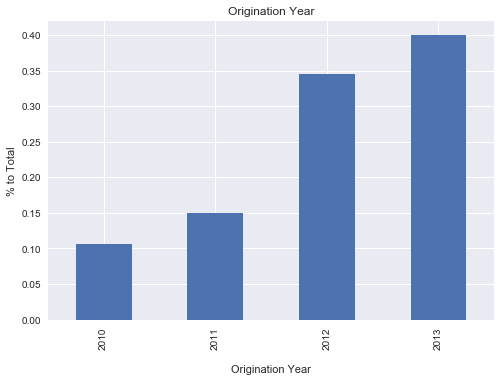

In [14]:
histogram(distr_dict['ory'], 'Origination Year')

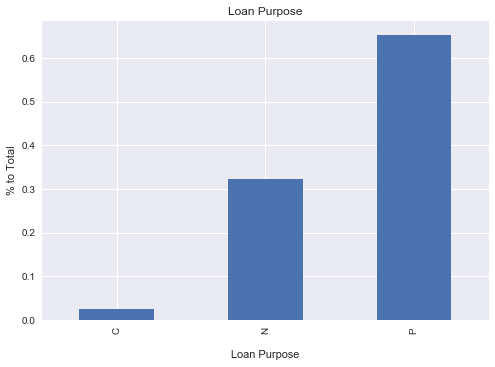

In [15]:
histogram(distr_dict['loan_purp'], 'Loan Purpose')

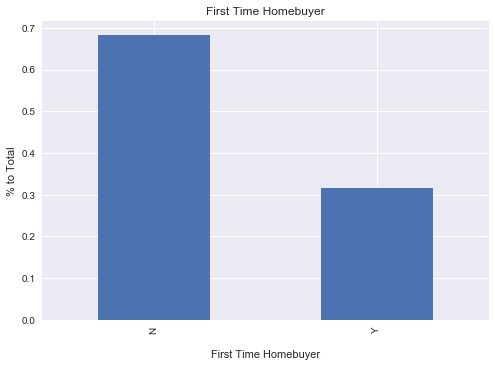

In [16]:
histogram(distr_dict['fhb_flag'], 'First Time Homebuyer')

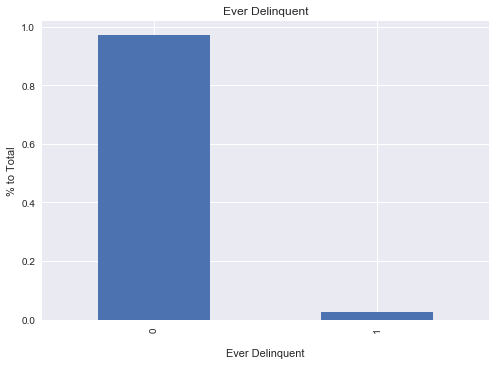

In [17]:
histogram(distr_dict['Ever_Delinquent'], 'Ever Delinquent')

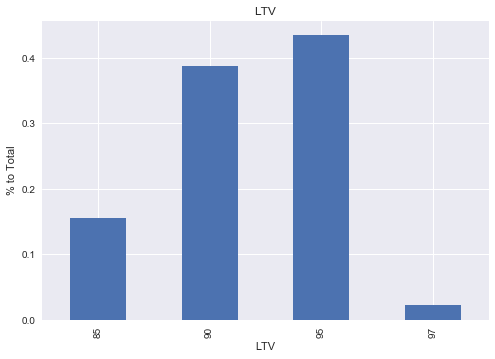

In [18]:
histogram_alt('ltv_new')

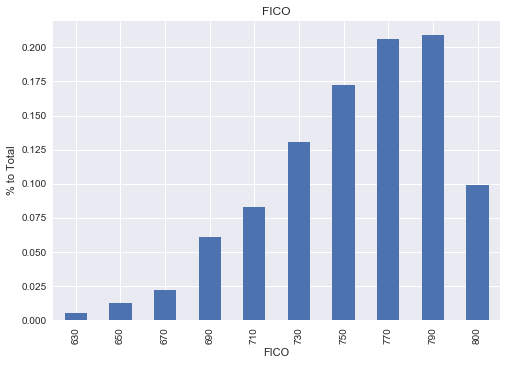

In [19]:
histogram_alt('FICO_new')

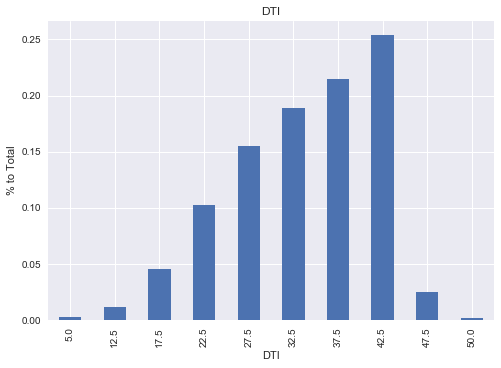

In [20]:
histogram_alt('dti_new')

# II. Modeling

In [21]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

**Due to unbalanced target data, we will need to upsample or downsample one of the class. Here I chose to downsample never delinquent (class 0) loans** 
** >> Select 10,000 per class **

In [22]:
target_col_name = 'Ever_Delinquent'
sample_size = 10000
df_new =df.groupby(target_col_name,as_index=False).apply(lambda x: x.sample(sample_size)).reset_index()

In [23]:
df_new.groupby(target_col_name).loan_id.nunique()

Ever_Delinquent
0    10000
1    10000
Name: loan_id, dtype: int64

### Selected Features to Fit the Model
- **Loan Purpose**: loan_purp 
- **Property Type**: prop_type
- **Occupancy Status**: occ_stat
- **DTI**: dti_new
- **FICO**: FICO_new
- **LTV**: ltv_new
- **First Time Home Buyer Indicator**: fhb_flag
- **MI Channel**: MI_chl
- **Number of Borrower**: no_bor
- **Origination Year**: ory

### Target : Ever Delinquent (Y/N -- 1/0)

In [24]:
# Create a new DataFrame to just include selected features and target
selected_col_name = ['loan_id', 'loan_purp', 'prop_type', 'occ_stat', 
                     'dti_new', 'FICO_new', 'ltv_new', 'fhb_flag', 
                     'MI_chl', 'no_bor','ory','Ever_Delinquent']

df_model = df_new[selected_col_name]

In [25]:
df_model.head()

,loan_id,loan_purp,prop_type,occ_stat,dti_new,FICO_new,ltv_new,fhb_flag,MI_chl,no_bor,ory,Ever_Delinquent
0,83113266,P,SF,O,27.5,750,90,Y,Delegated,2,2012,0
1,82879868,N,SF,O,27.5,730,90,N,Delegated,2,2010,0
2,83310818,P,SF,O,37.5,710,95,N,Non-Delegated,2,2013,0
3,83248460,N,SF,O,32.5,770,95,N,Delegated,2,2013,0
4,82971057,P,SF,O,37.5,710,95,Y,Delegated,2,2012,0


In [26]:
# Split table into "target" vs. "features"
# Include loan_id because this is the key to match other tables
X = df_model.iloc[:,0:-1].values
y = df_model.iloc[:,[0, -1]].values

In [27]:
# Encode Categorical Columns to Dummy Variable
feature_ls = ['loan_purp', 'prop_type', 'occ_stat', 'dti_new', 'FICO_new', 
              'ltv_new', 'fhb_flag', 'MI_chl', 'no_bor','ory']
              
df_X = pd.DataFrame((df_model.iloc[:,1:-1].values), columns=feature_ls)

# Create dummy variable and drop one value for each feature
df_X_dummy = pd.get_dummies(df_X, drop_first=True).astype(np.float64)

In [28]:
df_X_dummy.shape

(20000, 32)

In [29]:
df_X_dummy.head()

,loan_purp_N,loan_purp_P,prop_type_MH,prop_type_SF,occ_stat_S,dti_new_12.5,dti_new_17.5,dti_new_22.5,dti_new_27.5,dti_new_32.5,...,FICO_new_800,ltv_new_90,ltv_new_95,ltv_new_97,fhb_flag_Y,MI_chl_Non-Delegated,no_bor_2,ory_2011,ory_2012,ory_2013
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [30]:
df_model = df_model.join(df_X_dummy)
df_model.head()

,loan_id,loan_purp,prop_type,occ_stat,dti_new,FICO_new,ltv_new,fhb_flag,MI_chl,no_bor,...,FICO_new_800,ltv_new_90,ltv_new_95,ltv_new_97,fhb_flag_Y,MI_chl_Non-Delegated,no_bor_2,ory_2011,ory_2012,ory_2013
0,83113266,P,SF,O,27.5,750,90,Y,Delegated,2,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,82879868,N,SF,O,27.5,730,90,N,Delegated,2,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,83310818,P,SF,O,37.5,710,95,N,Non-Delegated,2,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,83248460,N,SF,O,32.5,770,95,N,Delegated,2,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,82971057,P,SF,O,37.5,710,95,Y,Delegated,2,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [31]:
# Create threshold list - here we use FICO as threshold model feature
thresh_feature_ls = ['loan_id', 'FICO_new_650', 'FICO_new_670', 'FICO_new_690',
                     'FICO_new_710', 'FICO_new_730', 'FICO_new_750',
                     'FICO_new_770', 'FICO_new_790', 'FICO_new_800']

# New feature list after creation of dummy variables
feature_ls_new = ['loan_id'] + list(df_X_dummy.columns.values)

# Model target list
target = ['Ever_Delinquent']

# Change the transformed dataframe to array
X = df_model[feature_ls_new].as_matrix()
X_thresh = df_model[thresh_feature_ls].as_matrix()
y = df_model[target].as_matrix().ravel()

In [32]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_thresh_train, X_thresh_test, y_thresh_train, y_thresh_test = train_test_split(X_thresh, y, test_size = 0.2, random_state = 0)

### Threshold Creation - Based on FICO Only Prediction

In [33]:
clf_thresh = LogisticRegression()
clf_thresh.fit(X_thresh_train[:, 1:], y_thresh_train)
y_thresh_pred = clf_thresh.predict(X_thresh_test[:, 1:])
print('ROC AUC Score Threshold is %s' % (roc_auc_score(y_thresh_test, y_thresh_pred)))

ROC AUC Score Threshold is 0.656107904971


### Fitting - Applying Different Classifiers on Training Set

In [34]:
# prepare models
models = []
models.append(('LR', LogisticRegression(random_state=0)))
models.append(('LDA', LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')))
models.append(('KNN', KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)))
models.append(('CART', DecisionTreeClassifier(criterion='entropy', random_state=0)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel="linear", random_state=0)))
models.append(('SVMKernel', SVC(kernel="poly", random_state=0)))
models.append(('RF', RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)))

LR: 0.741572 (0.018733)
LDA: 0.733755 (0.017979)
KNN: 0.656545 (0.017935)
CART: 0.621446 (0.015338)
NB: 0.695944 (0.019894)
SVM: 0.728301 (0.021162)
SVMKernel: 0.713313 (0.014212)
RF: 0.665516 (0.015130)


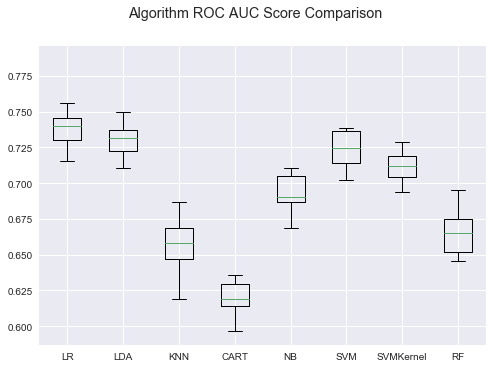

In [35]:
# prepare configuration for cross validation test harness
seed = 7

# Compare AUC score among different models
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train[:, 1:], y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm ROC AUC Score Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [36]:
# Find out the probablity of loan in claim with the ever deliquent status
(df[df['claim_flag'] == 1]
  .groupby('Ever_Delinquent')
  .loan_id.nunique()/df.groupby('Ever_Delinquent').loan_id.nunique()
).mul(100).round(1).astype(str) + '%'

Ever_Delinquent
0    nan%
1    8.5%
Name: loan_id, dtype: object

### Perform Regularization and Hyperparameter Tuning on Best Performed Model

In [37]:
# Create logistic regression
lr = LogisticRegression(random_state=0)

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 10-fold cross validation
clf = GridSearchCV(lr, hyperparameters, cv=10, verbose=0)

In [38]:
# Fit grid search
best_model = clf.fit(X_train[:, 1:], y_train)

In [39]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 1.0


In [40]:
penalty = best_model.best_estimator_.get_params()['penalty']
c = best_model.best_estimator_.get_params()['C']

# Model Evaluation

In [41]:
# Use the best hyperparameter to finalize the model
clf_final = LogisticRegression(penalty=penalty, C=c, random_state=0)
clf_final.fit(X_train[:, 1:], y_train)

# Predicting the Test set results
y_pred = clf_final.predict(X_test[:, 1:])

In [42]:
clf_final.coef_

array([[-0.56174856, -0.62129331,  0.24802107,  0.26688897,  0.41682897,
         0.02638395, -0.13645103,  0.08213567,  0.07389669,  0.26087577,
         0.43351206,  0.75412268,  0.90100841, -0.13274576,  0.22174206,
        -0.44250641, -0.82801467, -1.13542571, -1.59125001, -1.89302045,
        -2.29900899, -2.59551517, -2.70518546,  0.18413126,  0.50948457,
         0.75039509, -0.05892183,  0.0489045 , -0.80728304, -0.34224921,
        -0.64089296, -0.73396589]])

In [43]:
df_X_dummy.columns.values

array(['loan_purp_N', 'loan_purp_P', 'prop_type_MH', 'prop_type_SF',
       'occ_stat_S', 'dti_new_12.5', 'dti_new_17.5', 'dti_new_22.5',
       'dti_new_27.5', 'dti_new_32.5', 'dti_new_37.5', 'dti_new_42.5',
       'dti_new_47.5', 'dti_new_50.0', 'FICO_new_650', 'FICO_new_670',
       'FICO_new_690', 'FICO_new_710', 'FICO_new_730', 'FICO_new_750',
       'FICO_new_770', 'FICO_new_790', 'FICO_new_800', 'ltv_new_90',
       'ltv_new_95', 'ltv_new_97', 'fhb_flag_Y', 'MI_chl_Non-Delegated',
       'no_bor_2', 'ory_2011', 'ory_2012', 'ory_2013'], dtype=object)

In [44]:
d = {"Feature":df_X_dummy.columns.values, "Coefficients":clf_final.coef_[0]}
pd.DataFrame.from_dict(d)

,Coefficients,Feature
0,-0.561749,loan_purp_N
1,-0.621293,loan_purp_P
2,0.248021,prop_type_MH
3,0.266889,prop_type_SF
4,0.416829,occ_stat_S
5,0.026384,dti_new_12.5
6,-0.136451,dti_new_17.5
7,0.082136,dti_new_22.5
8,0.073897,dti_new_27.5
9,0.260876,dti_new_32.5


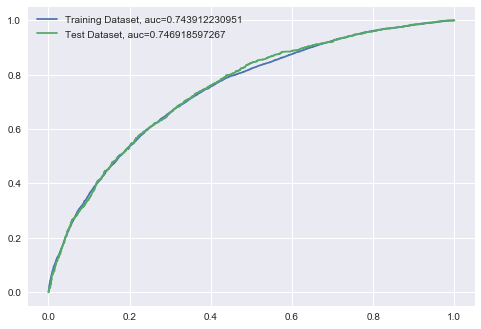

In [45]:
# Plot the ROC of the training set vs. the test set

from sklearn.metrics import roc_curve

# For Training Dataset, plot roc curve
fpr, tpr, thresholds = roc_curve(y_train, clf_final.predict_proba(X_train[:, 1:])[:,1])
auc = roc_auc_score(y_train, clf_final.predict_proba(X_train[:, 1:])[:,1])
plt.plot(fpr,tpr,label="Training Dataset, auc="+str(auc))

# For Test Dataset, plot roc curve
fpr, tpr, thresholds = roc_curve(y_test, clf_final.predict_proba(X_test[:, 1:])[:,1])
auc = roc_auc_score(y_test, clf_final.predict_proba(X_test[:, 1:])[:,1])
plt.plot(fpr,tpr,label="Test Dataset, auc="+str(auc))


plt.legend(loc=0)

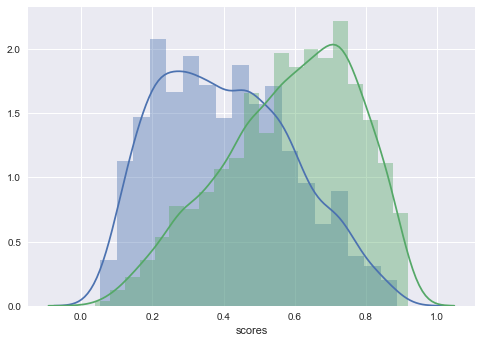

In [46]:
y_hats_test = clf_final.predict_proba(X_test[:, 1:])
test_eval = pd.DataFrame({'class':y_test, 'scores': list(zip(*y_hats_test))[0]})
class1_scores = test_eval[test_eval['class'] == 1]['scores']
class0_scores = test_eval[test_eval['class'] == 0]['scores']
sns.distplot(class1_scores, label = "class1_scores")
sns.distplot(class0_scores, label = "class0_scores")

# Calibration Plot

### Check if test set has the same class distribution compared to total population

In [47]:
# Total Population
ICD.display(percent_format(agg_column(df, 'Ever_Delinquent'), 1))

,Ever_Delinquent,percent
0,0,97.3%
1,1,2.7%


In [48]:
# Test set
df_test = pd.DataFrame(X_test, columns=feature_ls_new)
df_test.loc[:,'Ever_Delinquent'] = y_test
df_test['Ever_Delinquent'].value_counts()

1    2006
0    1994
Name: Ever_Delinquent, dtype: int64

In [49]:
# Since test set is not representative to actual population, resample among test set
# downsize test set making class 1 : class0 = 2.7% : 97.3%
df_test_class1 = df_test[df_test['Ever_Delinquent'] == 1]
df_test_class1 = df_test_class1.sample(frac=0.027, replace=True)
df_test_class0 = df_test[df_test['Ever_Delinquent'] == 0]
df_test_class1 = df_test_class1.sample(frac=0.973, replace=True)

# Stack class1 and class0 to create new test set
df_test_imbalanced = df_test_class0.append(df_test_class1)

# Split into feature array and target array
X_test_resample = df_test_imbalanced[feature_ls_new].as_matrix()
y_test_resample = df_test_imbalanced[target].as_matrix().ravel()

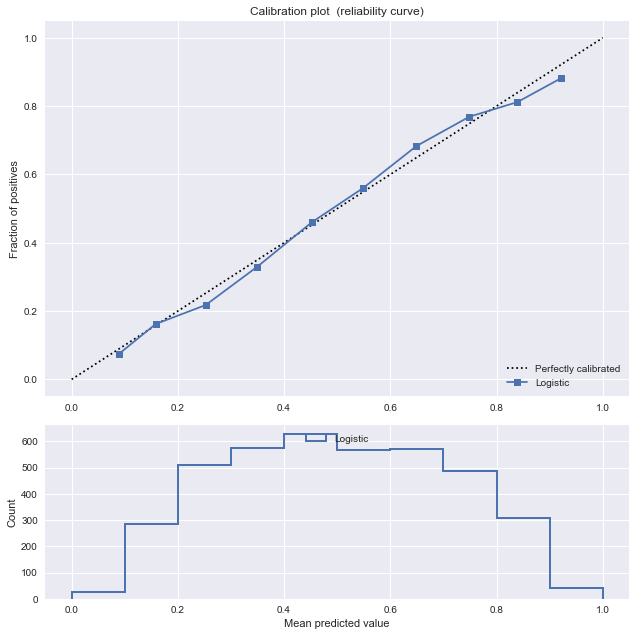

In [50]:
# Plot calibration plot on the original balanced test set for logistic regression model

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

plt.figure(figsize=(9, 9))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf_final, name in [(lr, 'Logistic')
                  ]:
    clf_final.fit(X_test[:, 1:] , y_test)
    if hasattr(clf_final, "predict_proba"):
        prob_pos = clf_final.predict_proba(X_test[:, 1:])[:, 1]
    else:  # use decision function
        prob_pos = clf_final.decision_function(X_test[:, 1:])
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plot  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

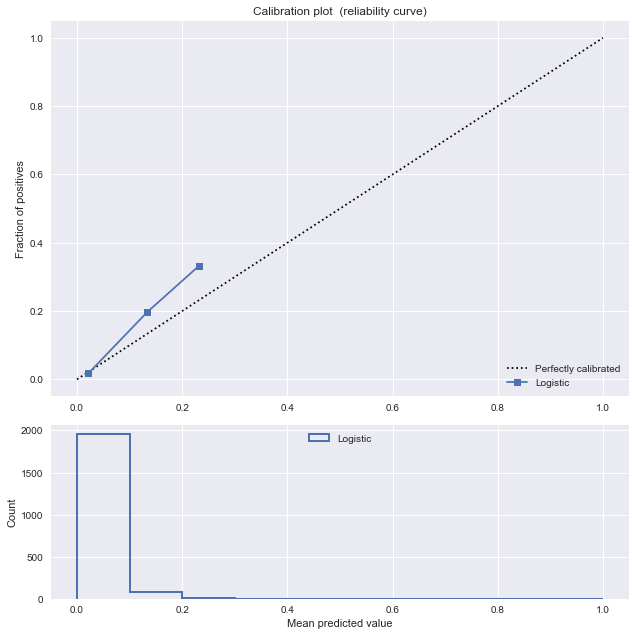

In [51]:
# Plot calibration plot on the resampled imbalanced test set for logistic regression model

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

plt.figure(figsize=(9, 9))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf_final, name in [(lr, 'Logistic')
                  ]:
    clf_final.fit(X_test_resample[:, 1:] , y_test_resample)
    if hasattr(clf_final, "predict_proba"):
        prob_pos = clf_final.predict_proba(X_test_resample[:, 1:])[:, 1]
    else:  # use decision function
        prob_pos = clf_final.decision_function(X_test_resample[:, 1:])
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test_resample, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plot  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

# Apply Probablity to Explain Business Impact
#### Include loan amount, coverage%, premium amount to calculate dollar amount

In [52]:
df_test.head()

,loan_id,loan_purp_N,loan_purp_P,prop_type_MH,prop_type_SF,occ_stat_S,dti_new_12.5,dti_new_17.5,dti_new_22.5,dti_new_27.5,...,ltv_new_90,ltv_new_95,ltv_new_97,fhb_flag_Y,MI_chl_Non-Delegated,no_bor_2,ory_2011,ory_2012,ory_2013,Ever_Delinquent
0,83224369.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,83114550.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,83087228.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
3,83357851.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,83258386.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [53]:
df.head()

,loan_id,ory,orig_upb,loan_purp,prop_type,multi_unit,orig_chn,occ_stat,dti_new,FICO_new,...,status,status_details,coverage,initial_premium,renewal_premium,Initial_Loan_Amt,dr_time_default,Ever_Delinquent,current_status,claim_flag
0,8092146,2010,142200,P,SF,0,R,O,22.5,800,...,Certificate Status,Canceled MI Certificate,25,0.00,73.47,142200,NaN,0,17.Cancel,0
1,8092147,2010,160550,P,SF,0,R,O,32.5,730,...,Certificate Status,Canceled MI Certificate,30,127.10,127.10,160550,NaN,0,17.Cancel,0
2,8092148,2010,224639,P,SF,0,R,O,27.5,800,...,Certificate Status,MI Certificate,25,5799.26,0.00,224639,NaN,0,01.Current,0
3,8092150,2010,340425,P,SF,0,R,O,22.5,730,...,Certificate Status,Canceled MI Certificate,17,0.00,141.84,340425,NaN,0,17.Cancel,0
4,8092152,2010,270750,P,SF,0,R,O,32.5,730,...,Certificate Status,Canceled MI Certificate,30,0.00,212.09,270750,NaN,0,17.Cancel,0


In [54]:
# Append probability to test set
df_test.loc[:,'delinquent_proba'] = test_eval['scores'].as_matrix()

# Append premium and loan amount to test set
additional_field = ['loan_id', 'Initial_Loan_Amt', 'initial_premium', 'renewal_premium', 'coverage', 'paymentplan']
df_test_new = pd.merge(df_test, df[additional_field], how='left', on=['loan_id'])

In [55]:
# Calculate expected premium paid
def expected_prem(row):
    if row['paymentplan'] == 'Monthly':
        val = row['renewal_premium'] * 12 *3
    elif row['paymentplan'] == 'Annual':
        val = row['renewal_premium'] *3
    else:
        val = row['initial_premium']
    return val

# Calculate expected claim paid
def expected_claim_paid(row):
    val = row['Initial_Loan_Amt'] * (row['coverage']/100) * row['delinquent_proba'] * 0.085
    return val

def claim_exceed_prem(row):
    if row['expected_claim_paid'] > row['expected_prem']:
        val = 1
    else:
        val = 0
    return val
    

In [56]:
df_test_new['expected_prem'] = df_test_new.apply(expected_prem, axis=1)
df_test_new['expected_claim_paid'] = df_test_new.apply(expected_claim_paid, axis=1)
df_test_new['claim_exceed_prem'] = df_test_new.apply(claim_exceed_prem, axis=1)
df_test_new['net'] = df_test_new['expected_prem'] - df_test_new['expected_claim_paid']

In [57]:
df_test_new.head()

,loan_id,loan_purp_N,loan_purp_P,prop_type_MH,prop_type_SF,occ_stat_S,dti_new_12.5,dti_new_17.5,dti_new_22.5,dti_new_27.5,...,delinquent_proba,Initial_Loan_Amt,initial_premium,renewal_premium,coverage,paymentplan,expected_prem,expected_claim_paid,claim_exceed_prem,net
0,8.32244e+07,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.131666,48880,0.0,39.51,25,Monthly,1422.36,136.761239,0,1285.598761
1,8.31146e+07,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.703085,258375,0.0,127.03,30,Monthly,4573.08,4632.321198,1,-59.241198
2,8.30872e+07,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.302097,111055,0.0,86.99,30,Monthly,3131.64,855.509151,0,2276.130849
3,8.33579e+07,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.159313,253000,0.0,132.83,12,Monthly,4781.88,411.122301,0,4370.757699
4,8.32584e+07,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.548272,340331,0.0,190.02,30,Monthly,6840.72,4758.142155,0,2082.577845


In [58]:
ICD.display(percent_format(agg_column(df_test_new, 'claim_exceed_prem'), 1))

,claim_exceed_prem,percent
0,0,86.4%
1,1,13.6%


In [59]:
df_test_new['net'].sum()

8503515.106221579

In [60]:
#df_claim_exceed_prem = df_test_new[df_test_new['claim_exceed_prem']==1]
#df_claim_exceed_prem['net'].sum()
df_test_new.groupby(['claim_exceed_prem'])[['net']].sum()

,net
claim_exceed_prem,
0,8.839167e+06
1,-3.356520e+05


## If analyzing the dollar impact on unsampled data set

In [61]:
# Get list of loan_id from all dataset
id_list = df['loan_id'].tolist()
id_list_model = df_model['loan_id'].tolist()

# Create unsampled dataset
df_unsampled = df[np.logical_not(df['loan_id'].isin(id_list_model))]
df_unsampled = df_unsampled[selected_col_name]

X_unsample = df_unsampled.iloc[:,0:-1].values
y_unsample = df_unsampled.iloc[:,[0, -1]].values

df_X_unsample = pd.DataFrame((df_unsampled.iloc[:,1:-1].values), columns=feature_ls)
df_X_dummy_unsample = pd.get_dummies(df_X_unsample, drop_first=True).astype(np.float64)

# Add IDs in data frame before join
df_X_dummy_unsample['loan_id'] = df_unsampled['loan_id']
df_unsampled['loan_id'] = df_unsampled['loan_id']
df_unsampled = pd.merge(df_unsampled, df_X_dummy_unsample, on='loan_id')

X_unsample = df_unsampled[feature_ls_new].as_matrix()
y_unsample = df_unsampled[target].as_matrix().ravel()

In [62]:
df_X_dummy_unsample.shape

(458262, 34)

In [63]:
df_unsampled.shape

(439229, 45)